In [1]:
! pip install googletrans stopwordsiso wordcloud

In [1]:
import json

import pandas as pd

import scipy.stats as stats

from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
data = json.load(open(f'../{data_dir}/labelbox_sample_annotated.json'))
data.keys()

dict_keys(['d16ec044', '3fefb024'])

In [3]:
dfs = []
for annotator in data.keys():
    df_annotator = pd.DataFrame.from_records(data[annotator])
    df_annotator['annotator'] = annotator
    dfs.append(df_annotator)

df = pd.concat(dfs)
df["trigger_level"] = df["trigger_level"].astype(int)

In [4]:
df.columns

Index(['emotion', 'emotion_class', 'trigger_level', 'context',
       'context_locations', 'description', 'created_at', 'created_by', 'text',
       'id', 'annotator'],
      dtype='object')

In [5]:
df.head(2)

emotion emotion_class  trigger_level  \
0      anger      negative              4   
1  undefined      positive              1   

                                             context context_locations  \
0  [–°–®–ê –ø–æ —Ä–∞–∑–Ω—ã–º –∫–∞–Ω–∞–ª–∞–º –ø—ã—Ç–∞—é—Ç—Å—è —É–±–µ–¥–∏—Ç—å —Å–≤–æ–∏—Ö ...      [[300, 452]]   
1                                                 []                []   

  description                     created_at created_by  \
0        None  2024-05-03T09:23:42.000+00:00   d16ec044   
1        None  2024-05-03T09:32:28.000+00:00   d16ec044   

                                                text  \
0  –ü—É—Ç–∏–Ω: –¢–µ, –∫—Ç–æ –ø–ª–∞–Ω–∏—Ä–æ–≤–∞–ª–∏ —ç—Ç–æ—Ç —Ç–µ—Ä–∞–∫—Ç, —Ä–∞—Å—Å—á–∏...   
1  ¬´–ß–∞–¥—ã—Ä-–õ—É–Ω–≥–∞ ‚Äî –≥–æ—Ä–æ–¥ –Ω–∞ —Å–µ–º–∏ —Ö–æ–ª–º–∞—Ö¬ª: –≤ –ì–∞–≥–∞—É–∑...   

                                     id annotator  
0  e19f77b7-f1a3-4f8a-b160-4af23deef647  d16ec044  
1  667ec738-34fe-4ced-b193-f97c47c4c9ce  d16ec044

In [7]:
df_d16ec044 = df[df.annotator == 'd16ec044'].sort_values(by='id')
df_3fefb024 = df[df.annotator == '3fefb024'].sort_values(by='id')
df_d16ec044.shape, df_3fefb024.shape

((236, 11), (236, 11))

In [8]:
def get_location_len(location):
    try:
        return location[1]-location[0]
    except:
        return None

df_d16ec044.explode('context_locations')['context_locations'].apply(get_location_len).mean()

47.621428571428574

In [9]:
df_3fefb024.explode('context_locations')['context_locations'].apply(get_location_len).mean()

18.590551181102363

In [10]:
df['annotator_for'] = df['created_by'].map({'d16ec044': 'persona_1', '3fefb024': 'persona_2'})

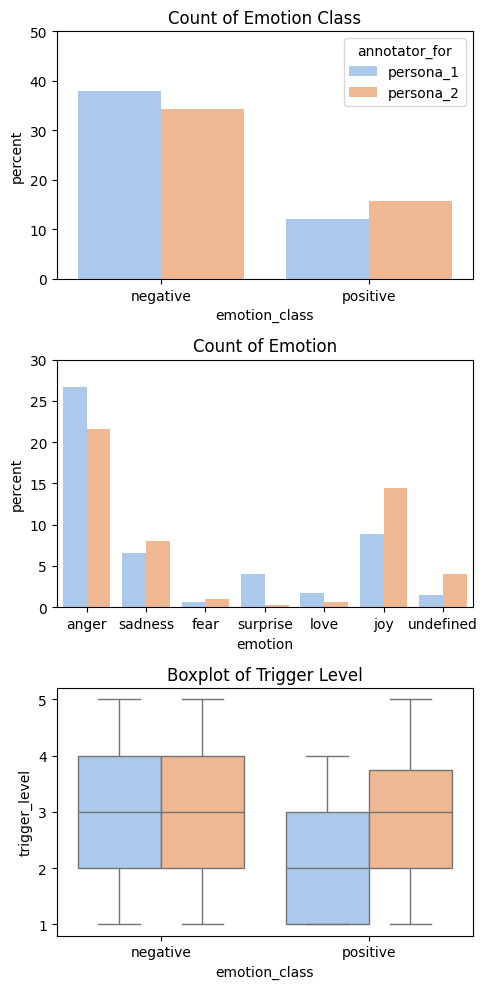

In [11]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 10))

plt.subplot(3, 1, 1)
ax11 = sns.countplot(data=df, x='emotion_class', hue='annotator_for', order=["negative", "positive"], stat='percent', palette='pastel')
ax11.set_ylim(0, 50)
plt.title('Count of Emotion Class')

plt.subplot(3, 1, 2)
a12 = sns.countplot(data=df, x='emotion', hue='annotator_for',
                    order=["anger", "sadness", "fear", "surprise", "love", "joy", "undefined"], stat='percent', palette='pastel',
                   legend=False)
a12.set_ylim(0, 30)
plt.title('Count of Emotion')

plt.subplot(3, 1, 3)
a13 = sns.boxplot(data=df, y='trigger_level', x='emotion_class', hue='annotator_for', order=["negative", "positive"], palette='pastel',
                 legend=False)
# a13.set_ylim(0, 30)
plt.title('Boxplot of Trigger Level')

# Display the plots
plt.tight_layout()
plt.savefig('eda.png')
plt.show()

In [12]:
df.trigger_level.describe()

count    472.000000
mean       2.855932
std        1.178544
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: trigger_level, dtype: float64

In [13]:
### Categorical Variables: 'emotion' and 'emotion_class'
# Chi-Squared Test for 'emotion'
contingency_emotion = pd.crosstab(df_d16ec044['emotion'], df_3fefb024['emotion'])
_, p_emotion, _, _ = stats.chi2_contingency(contingency_emotion)

# Chi-Squared Test for 'emotion_class'
contingency_emotion_class = pd.crosstab(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])
_, p_emotion_class, _, _ = stats.chi2_contingency(contingency_emotion_class)

print()
print("Chi-Squared Test for Emotion:")
print("P-value =", p_emotion)

print("Chi-Squared Test for Emotion Class:")
print("P-value =", p_emotion_class)

print()
print("Normality Test for Trigger Level:")
_, p_value_1 = stats.normaltest(df_d16ec044['trigger_level'])
_, p_value_2 = stats.normaltest(df_3fefb024['trigger_level'])
print(f"Normality Test P-value For d16ec044 =", p_value_1)
print(f"Normality Test P-value For 3fefb024 =", p_value_2)

# Using Mann-Whitney U Test as a non-parametric alternative if normality is not assumed
u_stat, p_trigger = stats.mannwhitneyu(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'], alternative='two-sided')

print("Mann-Whitney U Test for Trigger Level:")
print("P-value =", p_trigger)


Chi-Squared Test for Emotion:
P-value = 5.944718173448189e-09
Chi-Squared Test for Emotion Class:
P-value = 0.26886250893495856

Normality Test for Trigger Level:
Normality Test P-value For d16ec044 = 2.118182467941346e-08
Normality Test P-value For 3fefb024 = 0.00041765766574110617
Mann-Whitney U Test for Trigger Level:
P-value = 0.025205095567695023


In [14]:
n_stats, p_value = stats.normaltest(df_3fefb024['trigger_level'])
p_value

0.00041765766574110617

# Annotation agreement

In [15]:
cohen_kappa_score(df_d16ec044['emotion'], df_3fefb024['emotion'])

0.016131955773065032

In [16]:
cohen_kappa_score(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])

-0.08131672597864759

In [17]:
cohen_kappa_score(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'])

0.12237261514297593

# Context evaluation

In [18]:
def calc_span_intersection(true_context: list[tuple], predicted_context: list[tuple]):
    correct_pairs = []
    for true_start, true_end in true_context:
        true_chars = list(range(true_start, true_end + 1))
        for pred_start, pred_end in predicted_context:
            pred_chars = list(range(pred_start, pred_end + 1))
            intersection = sorted(set(true_chars).intersection(set(pred_chars)))
            if not intersection:
                continue
            correct_pairs.append((intersection[0], intersection[-1]))
    return correct_pairs

def calc_proportional_overlap(ann1_labels, ann2_labels):
    overlap_labels_total, overlap_labels_len = 0, 0
    ann1_labels_total, ann1_labels_len = 0, 0
    ann2_labels_total, ann2_labels_len = 0, 0
    overlaps_all = []
    for i, (ann1_labels_i, ann2_labels_i) in enumerate(zip(ann1_labels, ann2_labels)):
        ann1_labels_len += sum([e - s + 1 for s, e in ann1_labels_i])
        ann2_labels_len += sum([e - s + 1 for s, e in ann2_labels_i])
        # print(ann1_labels_len, ann2_labels_len)
        ann1_labels_total += len(ann1_labels_i)
        ann2_labels_total += len(ann2_labels_i)
        # print(ann1_labels_total, ann2_labels_total)
        overlaps = calc_span_intersection(ann1_labels_i, ann2_labels_i)
        overlaps_all.append(overlaps)
        overlap_labels_len += sum([e - s + 1 for s, e in overlaps])
        overlap_labels_total += len(overlaps)
        # print(overlap_labels_len, overlap_labels_total)
    return {
        "ann1_labels_len": ann1_labels_len, "ann1_labels_total": ann1_labels_total,
        "ann2_labels_len": ann2_labels_len, "ann2_labels_total": ann2_labels_total,
        "overlap_labels_len": overlap_labels_len, "overlap_labels_total": overlap_labels_total,
        "overlaps_all": overlaps_all,
    }

res = calc_proportional_overlap(df_d16ec044['context_locations'], df_3fefb024['context_locations'])

In [19]:
res['ann1_labels_len'] / res['ann1_labels_total'], res['ann2_labels_len'] / res['ann2_labels_total']

(48.621428571428574, 19.590551181102363)

In [20]:
(res['overlap_labels_len' ]) / (res['ann1_labels_len'] + res['ann2_labels_len'] - res['overlap_labels_len' ])

0.14203795092792104

# Overlaps

In [21]:
df_new = pd.DataFrame({
    'd16ec044': df_d16ec044['context_locations'],
    '3fefb024': df_3fefb024['context_locations'],
    'text': df_3fefb024['text'],
    'overlaps': res['overlaps_all'],
})

text_overlaps = []
for i, row in df_new.iterrows():
    text = row['text']
    text_overlap = [text[o[0]:o[1]+1] for o in row['overlaps']]
    text_overlaps.append(text_overlap)

df_new['text_overlaps'] = text_overlaps

In [22]:
text_overlap = ' '.join(df_new['text_overlaps'].apply(lambda x: ' '.join(x)).values)

In [23]:
from googletrans import Translator
import matplotlib.pyplot as plt

# Initialize the translator
translator = Translator()

# Function to translate text
def translate_to_english(text):
    try:
        translation = translator.translate(text, dest='en')
        return translation.text
    except Exception as e:
        return text

# Translate the text column to English
text_overlap_translated = translate_to_english(text_overlap)

In [24]:
import stopwordsiso

stopwordsiso.stopwords('en')

{'significantly',
 'theyd',
 'ma',
 'vu',
 'k',
 'and',
 'bb',
 'int',
 'ca',
 'five',
 'smallest',
 'werent',
 'they',
 'recent',
 "who'll",
 'didn',
 'pe',
 'give',
 'man',
 'whilst',
 'thru',
 'parting',
 'hid',
 'ourselves',
 'fify',
 'kz',
 'downed',
 'indeed',
 'means',
 'saying',
 'mo',
 "we've",
 'better',
 'ff',
 'due',
 'really',
 'similarly',
 'longest',
 'truly',
 'suggest',
 'say',
 'find',
 'bm',
 'order',
 'need',
 'newer',
 'oughtnt',
 'our',
 'call',
 'thatve',
 'bz',
 'webpage',
 'hopefully',
 'turned',
 'noted',
 'these',
 'vn',
 'greatest',
 'ts',
 'copy',
 'tm',
 'lt',
 'that',
 'iq',
 'going',
 'through',
 'gb',
 'substantially',
 "where'd",
 'bj',
 'td',
 'anything',
 'io',
 'invention',
 "we'd",
 'alongside',
 'goes',
 'want',
 'whose',
 'shown',
 'first',
 'oldest',
 'g',
 "shan't",
 'areas',
 'ran',
 'hereby',
 'differ',
 'za',
 'et-al',
 'om',
 'certainly',
 'ahead',
 'tends',
 'at',
 'opening',
 "'ve",
 'sa',
 'began',
 'f',
 'works',
 'biol',
 'seen',
 'pre

In [27]:
from wordcloud import WordCloud

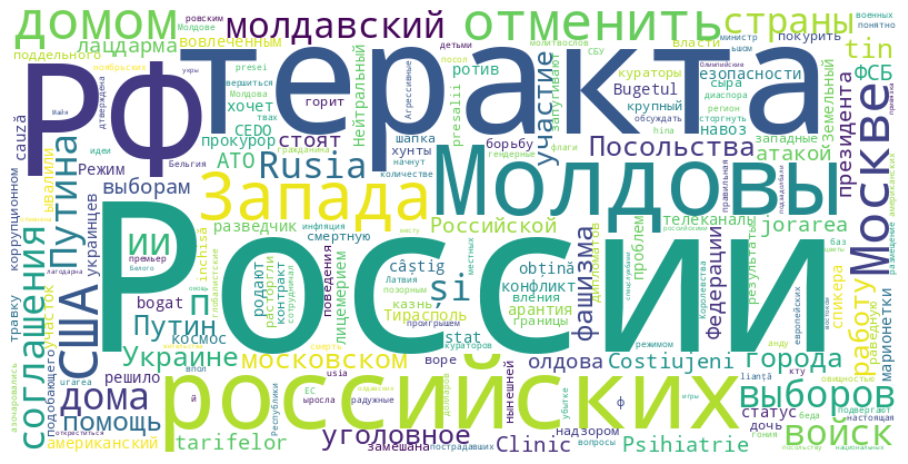

In [86]:
stopwords = stopwordsiso.stopwords('ro').union(stopwordsiso.stopwords('ru'))
wordcloud_original = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(text_overlap)
# wordcloud_translated = WordCloud(width=800, height=400, background_color='white',
#                                  stopwords=stopwordsiso.stopwords('en')).generate(text_overlap_translated)

# Plotting the word clouds
plt.figure(figsize=(10, 5))

# Display the word clouds
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.axis('off')

plt.tight_layout(pad=2.0)

plt.savefig('wordcloud.png')
plt.show()

In [42]:
print(wordcloud_original.words_.keys())

dict_keys(['–†–æ—Å—Å–∏–∏', '—Ç–µ—Ä–∞–∫—Ç–∞', '–†–§', '—Ä–æ—Å—Å–∏–π—Å–∫–∏—Ö', '–ú–æ–ª–¥–æ–≤—ã', '–ó–∞–ø–∞–¥–∞', '–ú–æ—Å–∫–≤–µ', '–°–®–ê', '–¥–æ–º–æ–º', '–æ—Ç–º–µ–Ω–∏—Ç—å', '–≤—ã–±–æ—Ä–æ–≤', '–ü—É—Ç–∏–Ω–∞', '—Å–æ–≥–ª–∞—à–µ–Ω–∏—è', '–¥–æ–º–∞', '–∏–∏', '–º–æ–ª–¥–∞–≤—Å–∫–∏–π', 'Rusia', '»ôi', '–≤–æ–π—Å–∫', '—Å—Ç—Ä–∞–Ω—ã', '–ø', '–£–∫—Ä–∞–∏–Ω–µ', '—É—á–∞—Å—Ç–∏–µ', '–º–æ—Å–∫–æ–≤—Å–∫–æ–º', '–ü–æ—Å–æ–ª—å—Å—Ç–≤–∞', '–≥–æ—Ä–æ–¥–∞', '—Ñ–∞—à–∏–∑–º–∞', '–ø–æ–º–æ—â—å', '—É–≥–æ–ª–æ–≤–Ω–æ–µ', 'tin', '–ü—É—Ç–∏–Ω', '—Ä–∞–±–æ—Ç—É', 'jorarea', 'tarifelor', 'Clinic', 'Psihiatrie', 'Costiujeni', '–≤—ã–±–æ—Ä–∞–º', '–ø—Ä–µ–∑–∏–¥–µ–Ω—Ç–∞', '–†–æ—Å—Å–∏–π—Å–∫–æ–π', '–§–µ–¥–µ—Ä–∞—Ü–∏–∏', '–æ–ª–¥–æ–≤–∞', '–ê–¢–û', '–ª–∞—Ü–¥–∞—Ä–º–∞', '–§–°–ë', '–∞—Ç–∞–∫–æ–π', '—Å—Ç–æ—è—Ç', '–∞–º–µ—Ä–∏–∫–∞–Ω—Å–∫–∏–π', '—Ä–∞–∑–≤–µ–¥—á–∏–∫', '–ª–∏—Ü–µ–º–µ—Ä–∏–µ–º', '–¢–∏—Ä–∞—Å–ø–æ–ª—å', '—Ö–æ—á–µ—Ç', '–≤–æ–≤–ª–µ—á–µ–Ω–Ω—ã–º', '–∫–æ–Ω—Ñ–ª–∏–∫—Ç', 'Bugetul', 'stat', 'bogat', 'ob»õinƒÉ', 'c√¢»ôtig', 'cauzƒÉ', 'CEDO', '—Ç–µ–ª–µ–∫–∞–Ω–∞–ª—

# Best triggers

In [47]:
df[df.emotion_class == 'positive'].value_counts('emotion')

emotion
joy          109
love          11
surprise       6
undefined      3
sadness        2
dtype: int64

In [48]:
df[df.emotion_class == 'negative'].value_counts('emotion')

emotion
anger        228
sadness       67
undefined     23
surprise      14
fear           8
joy            1
dtype: int64

In [54]:
df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))].value_counts('annotator_for')

annotator_for
persona_1    62
persona_2    54
dtype: int64

In [79]:
df_p1_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([5]))&(df.annotator_for == 'persona_1')]['context']
df_p2_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([5]))&(df.annotator_for == 'persona_2')]['context']

In [80]:
len(df_p1_triggers), len(df_p2_triggers)

(12, 25)

In [81]:
' '.join(df_p1_triggers.apply(' '.join).values)

'–ì—É—Ü—É–ª –Ω–µ –∏—Å–∫–ª—é—á–∞–µ—Ç, —á—Ç–æ –ö–∏—à–∏–Ω–µ–≤ –ø–æ–π–¥–µ—Ç –Ω–∞ –≤–≤–æ–¥ –≤–æ–π—Å–∫ –∏ —Ä–æ—Å–ø—É—Å–∫ –ì–∞–≥–∞—É–∑—Å–∫–æ–π –∞–≤—Ç–æ–Ω–æ–º–∏–∏ –≤ —Å–ª—É—á–∞–µ –æ–±—ä—è–≤–ª–µ–Ω–∏—è –µ—é –Ω–µ–∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –ë–∞—à–∫–∞–Ω —Å–¥–µ–ª–∞–ª–∞ —Ç–æ, —á–µ–≥–æ –∂–¥–∞–ª –≤–µ—Å—å –≥–∞–≥–∞—É–∑—Å–∫–∏–π –Ω–∞—Ä–æ–¥ –∏ —á–∞—Å—Ç—å –∂–∏—Ç–µ–ª–µ–π –æ—Å—Ç–∞–ª—å–Ω–æ–π –†–ú –•–æ–∑—è–µ–≤–∞ –ú–∞–π–∏ –°–∞–Ω–¥—É –∫–∞–∫ –≤–µ—Ä–Ω–∞—è —Å–æ–±–∞–∫–∞ –∑–∞–ø–∞–¥–Ω—ã–µ –∫—É—Ä–∞—Ç–æ—Ä—ã —Ä–µ–∂–∏–º –ú–∞–π–∏ –°–∞–Ω–¥—É –Ω–µ —Ç–æ–ª—å–∫–æ –≤—ã—Å—Ç–∞–≤–∏–ª–∏ —Å–µ–±—è –Ω–∞ –ø–æ—Å–º–µ—à–∏—â–µ –≥—Ä–∞–Ω–∏—Ü—ã –¥–∏–∫—Ç–∞—Ç—É—Ä—ã –∏ –±–µ—Å–ø—Ä–µ–¥–µ–ª–∞ –æ–Ω–∏ –º–æ–≥—É—Ç —Ä–∞—Å—à–∏—Ä—è—Ç—å –±–µ—Å–∫–æ–Ω–µ—á–Ω–æ –ø–æ—Å—Ç—Ä–∞–¥–∞–≤—à–∏–º ‚ùóÔ∏è–ü–æ–ª—è–∫–æ–≤–∞, ITV –ø—Ä–∏–Ω—è—Ç—å –Ω–∞ —Ä–∞–±–æ—Ç—É –ª—é–¥–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Ç–µ—Ä—è–ª–∏ —Ä–∞–±–æ—Ç—É –ø—Ä–∞–∑–¥–Ω—É—è 80-–ª–µ—Ç–∏–µ –æ—Å–≤–æ–±–æ–∂–¥–µ–Ω–∏—è –≥–æ—Ä–æ–¥–∞ –æ—Ç —Ñ–∞—à–∏–∑–º–∞, —à–∫–æ–ª—å–Ω–∏–∫–∏ –ø–æ—é—Ç –ö–∞—Ç—é—à—É –≤—ã—Å—Ç–∞–≤–∫—É –≤–æ–µ–Ω–Ω–æ–π –∞—Ç—

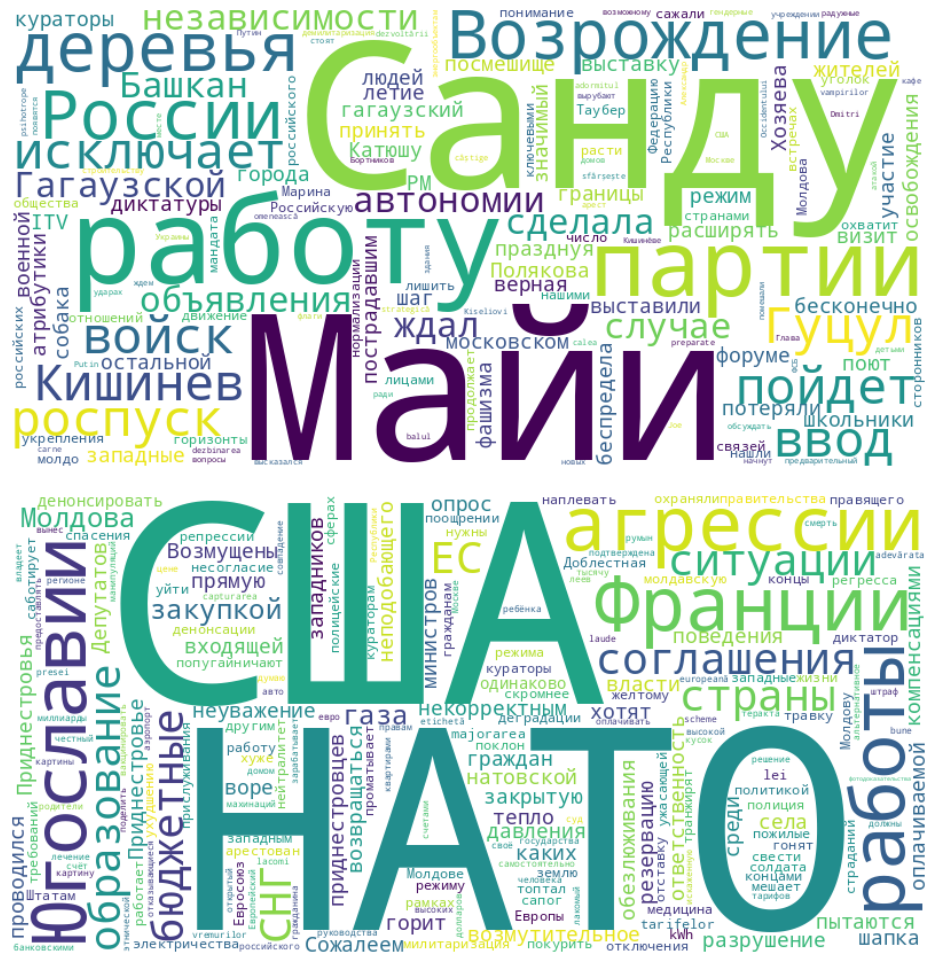

In [83]:
stopwords = stopwordsiso.stopwords('ro').union(stopwordsiso.stopwords('ru'))
wordcloud1 = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(' '.join(df_p1_triggers.apply(' '.join).values))
wordcloud2 = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(' '.join(df_p2_triggers.apply(' '.join).values))

plt.figure(figsize=(10, 10))  # Set the figure size

# First word cloud
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
# plt.title('Word Cloud 1')

# Second word cloud
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
# plt.title('Word Cloud 2')

# Show the plot
plt.tight_layout(pad=2.0)

plt.savefig('wordcloud_biggest_triggers.png')
plt.show()

In [ ]:
df_p1_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_1')]['context']
df_p2_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_2')]['context']

In [71]:
df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_1')]

emotion emotion_class  trigger_level  \
0     anger      negative              4   
11    anger      negative              4   
12    anger      negative              4   
13    anger      negative              4   
14    anger      negative              4   
..      ...           ...            ...   
216   anger      negative              4   
219   anger      negative              4   
221   anger      negative              5   
222   anger      negative              5   
233   anger      negative              4   

                                               context  \
0    [–°–®–ê –ø–æ —Ä–∞–∑–Ω—ã–º –∫–∞–Ω–∞–ª–∞–º –ø—ã—Ç–∞—é—Ç—Å—è —É–±–µ–¥–∏—Ç—å —Å–≤–æ–∏—Ö ...   
11   [–ï–° ‚Äî —ç—Ç–æ –Ω–∞—Å—Ç–æ—è—â–∞—è –±–µ–¥–∞ –¥–ª—è –ú–æ–ª–¥–æ–≤—ã. –ò —Ç–æ–≥–¥–∞ ...   
12          [¬´–æ—Ç–º–µ–Ω–∏—Ç—å¬ª –º–æ–ª–¥–∞–≤—Å–∫–∏–π —è–∑—ã–∫, —Ä—É–º—ã–Ω—Å–∫–∏–π–Ω–µ—Ç]   
13   [–ë–æ–≥–¥–∞–Ω –¶—ã—Ä–¥—è, –í–∏–∫—Ç–æ—Ä–∏–∏ –§—É—Ä—Ç—É–Ω—ç, –∑–∞–∫—Ä—ã–ª–∞ —É–≥–æ–ª–æ...   
14   [–∫–æ–≥–¥–∞ —Ä—É—Å—Å–∫–∏–µ –ª—é–¥–∏ —Å –æ—Ä—É–∂–∏–µ–º –≤ —Ä—É–∫–∞—Ö —Å–º–µ—à–∞–ª–∏ ...   
..                                                 ...   
216  [–ú–æ–ª–¥–æ–≤–∞ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞–µ—Ç—Å—è —Å—Ç—Ä–∞–Ω–∞–º–∏ –ù–ê–¢–û –≤ –∫–∞—á–µ—Å...   
219  [—Ä–∞–∑–æ—á–∞—Ä–æ–≤–∞–ª–∏—Å—å –≤ –ú–∞–π–µ –°–∞–Ω–¥—É, –¥–µ–ø—É—Ç–∞—Ç –í–∞—Å–∏–ª–µ –ë...   
221  [–ì–ª–∞–≤–∞ –§–°–ë –†–æ—Å—Å–∏–∏, –∑–∞ –∞—Ç–∞–∫–æ–π –≤ ‚Äã‚Äã–ú–æ—Å–∫–≤–µ —Å—Ç–æ—è—Ç ...   
222  [Putin, Dmitri Kiseliovi, preparate psihotrope...   
233                        [Andrei NƒÉstase, inoportun]   

                                     context_locations  \
0                                         [[300, 452]]   
11                            [[648, 719], [257, 347]]   
12                            [[364, 389], [509, 520]]   
13                     [[0, 11], [63, 78], [186, 219]]   
14                             [[83, 171], [450, 504]]   
..                                                 ...   
216                             [[3, 122], [335, 371]]   
219       [[15, 41], [52, 70], [552, 599], [826, 879]]   
221                    [[9, 24], [38, 67], [149, 167]]   
222  [[56, 60], [76, 91], [265, 285], [476, 498], [...   
233                               [[68, 81], [51, 59]]   

                                           description  \
0                                                 None   
11   This post triggers negatives emotions because ...   
12   It triggers strong negative emotions because t...   
13                                                None   
14                                                None   
..                                                 ...   
216                                               None   
219                                               None   
221  The post arouses anger because Russia as usual...   
222  The post arouses anger because Putin is delusi...   
233                                               None   

                        created_at created_by  \
0    2024-05-03T09:23:42.000+00:00   d16ec044   
11   2024-05-02T17:24:52.000+00:00   d16ec044   
12   2024-05-02T17:37:02.000+00:00   d16ec044   
13   2024-05-03T08:42:57.000+00:00   d16ec044   
14   2024-05-03T08:44:49.000+00:00   d16ec044   
..                             ...        ...   
216  2024-05-04T16:53:08.000+00:00   d16ec044   
219  2024-05-04T16:56:28.000+00:00   d16ec044   
221  2024-05-04T17:00:22.000+00:00   d16ec044   
222  2024-05-04T17:02:53.000+00:00   d16ec044   
233  2024-05-04T17:09:27.000+00:00   d16ec044   

                                                  text  \
0    –ü—É—Ç–∏–Ω: –¢–µ, –∫—Ç–æ –ø–ª–∞–Ω–∏—Ä–æ–≤–∞–ª–∏ —ç—Ç–æ—Ç —Ç–µ—Ä–∞–∫—Ç, —Ä–∞—Å—Å—á–∏...   
11   –í–∏—Ü–µ-—Å–ø–∏–∫–µ—Ä –ø–∞—Ä–ª–∞–º–µ–Ω—Ç–∞ –î–æ–π–Ω–∞ –ì–µ—Ä–º–∞–Ω –≤–º–µ—Å—Ç–µ —Å –ø...   
12   –ü–æ—Å–ª–µ —Å–ª–æ–≤ –í–ª–∞–¥–∏–º–∏—Ä–∞ –í–æ—Ä–æ–Ω–∏–Ω–∞ –æ —Ç–æ–º, —á—Ç–æ ¬´–æ–Ω–∏ ...   
13   –ë–æ–≥–¥–∞–Ω –¶—ã—Ä–¥—è –ø—Ä–æ–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–ª –Ω–æ–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ ...   
14   ‚ÄºÔ∏è10 –ª–µ—Ç –≤–æ–π–Ω—ã –Ω–∞ –î–æ–Ω–±–∞—Å

______________________